In [1]:
pip install "tf-models-official==2.13.1" 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.7/479.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
from os import path
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Flatten, Input, MaxPooling2D, Dropout, RandomFlip, Lambda, Cropping2D
import seaborn as sns
import matplotlib.pyplot as plt

plt.show()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
median_trian_shapes = (480, 612)

train = pd.read_csv('/kaggle/input/ukraine-ml-bootcamp-2023/train.csv')
test = pd.read_csv('/kaggle/input/ukraine-ml-bootcamp-2023/sample_submission.csv')

train_src = '/kaggle/input/ukraine-ml-bootcamp-2023/images/train_images'
test_src = '/kaggle/input/ukraine-ml-bootcamp-2023/images/test_images'

c_num = len(set(train['class_6']))
print('Train size:', train.shape[0])

Train size: 2360


**Split**

In [4]:
from sklearn.model_selection import train_test_split

plt.show()
train, val = train_test_split(train, test_size=0.05, stratify=train['class_6'])

In [5]:
%matplotlib inline

<Axes: xlabel='class_6', ylabel='count'>

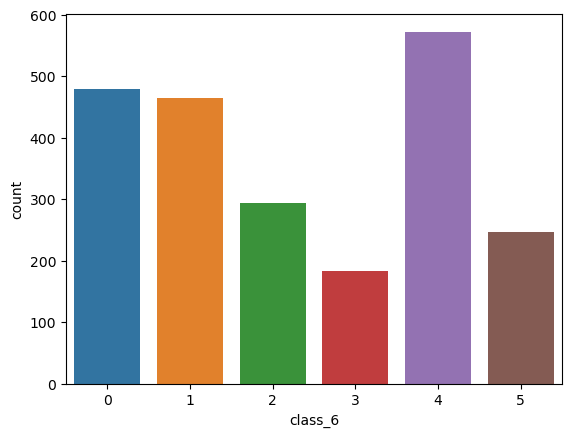

In [6]:
sns.countplot(x=train['class_6'])

<Axes: xlabel='class_6', ylabel='count'>

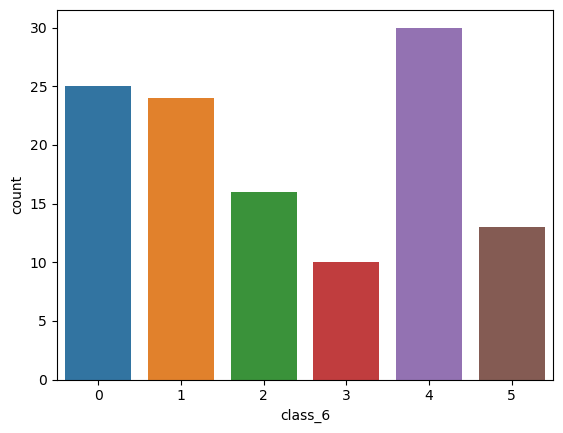

In [7]:
sns.countplot(x=val['class_6'])

After visualizing countplot we can see, that our data is partly unbalanced. For further insights lets visualize what those poses are.

In [8]:
def visualize_class(train, target, ax=plt):
    chosen_img = train[train['class_6'] == target]['image_id'].sample(1, replace=False)
    im_path = path.join(train_src, chosen_img.iloc[-1])
    ax.set_title(target)
    ax.imshow(plt.imread(im_path))
    
def visualize_images(train, target=-1):
    if target==-1:
        targets = range(c_num) 
    else:
        targets = [target] * 15
    
    _, axs = plt.subplots(3, 5, figsize=(9, 9))
    for ax, target in zip(np.array(axs).flatten(), targets):
        visualize_class(train, target, ax)

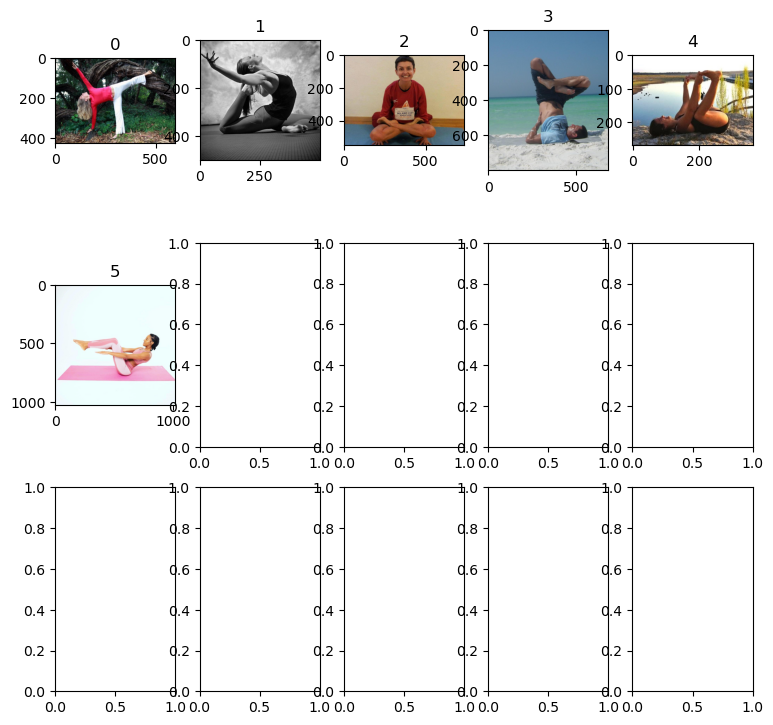

In [9]:
visualize_images(train)

Hardness is described in terms of human not machine

* class 0 - standing position, also includes bending forward in standing position (medium)
* class 1 - sitting posistion, also inclides bending, that make it harder to distinguish (medium) 
* class 2 - standing on arms (easy)
* class 3 - upper legs (easy)
* class 4 - laying (hard)
* class 5 - spine bending (hard)

wrong labeling observed  
class 4 and 5 hard to distinguish from one another  


Assumptions about models efficency  

Least data was given for 2,3 and 5 classes.  

Although, 5 classes was hard to identify as spine bending pose for human it should be easy to classify it for model, bacase human body ussualy takes position V,  reverse U and C, that should be easily captured by models. Problems lays in some images. Most problematic are elbow-knee position that can overlab with 4 class, bending positions where other parts of body are bring forrward that ruin earlier mentioned shapes and other poses that dont form distinguish forms but stil are considerend bending.  

Even given few examples class 3 should not bring any problems. Due to simplicity for human to identify and similarity for I and L shapes that should be easy for model to identofy and np visible overlaps with pther classes.

Class 2 was the easisest for human to identify, bacause all images include people staying on their hands. IMHO model can struggle with such unput, because unlike other tasks, where we can identify class by shape class 2 has wide variety of shapes, that change due to different angels and only way to 100% identify the pose is to say wheather image include persone staying on their hands.  

No comments on other classes due to assumption of enogh data for their proper classification

class 2 can be identify by separate model due to finding a set of different feature (hgand standing), unlike identifing body shape

class 5 no idea yet

In [10]:
train['class_6'] = train['class_6'].astype(str)
val['class_6'] = val['class_6'].astype(str)

In [11]:
width = 224
height = 224
print(width, height)

224 224


In [12]:
!pip install ultralytics 

from ultralytics import YOLO
mask_yolo = YOLO('yolov8m-seg.pt')

mask_yolo.to('cpu')

import cv2

preson_index = 0

def get_cropped_image(image):
    result = mask_yolo(image, verbose=False)
    image_shape = image.shape[:2]
    if preson_index in result[0].boxes.cls:
        mask_index = np.argmax((result[0].boxes.cls == preson_index).cpu().numpy().astype(int))
        mask = result[0].masks.data[mask_index].cpu().numpy()
        image = image * np.tile(np.expand_dims(cv2.resize(mask, image_shape[::-1]), axis=-1), (1, 1, 3))
        image = image[~np.all(image == 0, axis=(1, 2))]
        image = cv2.resize(image, image_shape)
        image[image == 0] = 255
        return image
    else:
        return image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.0/716.0 kB 11.5 MB/s eta 0:00:00


100%|██████████| 52.4M/52.4M [00:00<00:00, 234MB/s]


In [13]:
import tensorflow_models as tfm

rand_aug_1 = tfm.vision.augment.RandAugment(num_layers=1, magnitude=12.5, cutout_const=40.0, translate_const=25.0)
rand_aug_2 = tfm.vision.augment.RandAugment(num_layers=2, magnitude=10, cutout_const=40.0, translate_const=25.0)
rand_aug_3 = tfm.vision.augment.RandAugment(num_layers=3, magnitude=7.5, cutout_const=40.0, translate_const=25.0)


def augment(image):
    r_ = np.random.randint(4)
    if r_ == 0:
        return image
    elif r_ == 1:
        return get_cropped_image(image)
    else:
        r = np.random.randint(4)
        if  r == 0:
            return rand_aug_3.distort(image)
        elif r == 1: 
            return rand_aug_1.distort(image)
        elif r == 2:
            return rand_aug_2.distort(image)
        else:
            return rand_aug_2.distort(get_cropped_image(image))

In [14]:
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=augment)
datagen_val = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=get_cropped_image)
datagen_val_no_crop = tf.keras.preprocessing.image.ImageDataGenerator()

dataset_train = datagen_train.flow_from_dataframe(
    dataframe=train,
    directory=train_src,
    x_col='image_id',
    y_col='class_6',
    batch_size=24,
    shuffle=True,
    class_mode='categorical', 
    target_size=(width, height) 
)


dataset_val = datagen_val.flow_from_dataframe(
    dataframe=val,
    directory=train_src,
    x_col='image_id',
    y_col='class_6',
    batch_size=64,
    shuffle=False,
    class_mode='categorical',
   # color_mode='grayscale',
    target_size=(width, height)
)

dataset_val_no_crop = datagen_val_no_crop.flow_from_dataframe(
    dataframe=val,
    directory=train_src,
    x_col='image_id',
    y_col='class_6',
    batch_size=64,
    shuffle=False,
    class_mode='categorical',
   # color_mode='grayscale',
    target_size=(width, height)
)

Found 2242 validated image filenames belonging to 6 classes.
Found 118 validated image filenames belonging to 6 classes.
Found 118 validated image filenames belonging to 6 classes.


In [15]:
y_train = train['class_6']
y_val = val['class_6'] 

In [16]:
def conv_block(seq, filters, kernel_size, strides=(1, 1)):
    seq.add(Conv2D(filters, kernel_size, strides=strides))
    seq.add(BatchNormalization())
    seq.add(MaxPooling2D())
    return seq

def simple_model():
    seq =  tf.keras.Sequential()
    seq.add(Input((width, height, 1)))
    seq.add(RandomFlip(mode='horizontal'))
    seq.add(Lambda(lambda x: tf.math.round(x)))
    seq = conv_block(seq, 32, (3, 3))
    seq = conv_block(seq, 32, (3, 3))
    seq = conv_block(seq, 64, (3, 3))
    seq = conv_block(seq, 64, (3, 3))
    seq.add(Flatten())
    seq.add(Dense(512, activation='relu'))
    seq.add(Dropout(0.2))
    seq.add(Dense(6, activation='softmax'))
    return seq

In [17]:
from tensorflow.keras import backend as K

def micro_f1_score(y_true, y_pred):
    # Convert predictions to one-hot vectors
    y_pred = K.one_hot(K.argmax(y_pred), num_classes=6)

    # Calculate true positives, false positives, and false negatives over all classes
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    # Micro-average precision and recall
    micro_precision = K.sum(tp) / (K.sum(tp + fp) + K.epsilon())
    micro_recall = K.sum(tp) / (K.sum(tp + fn) + K.epsilon())

    # Calculate micro-averaged F1-score
    micro_f1 = 2 * micro_precision * micro_recall / (micro_precision + micro_recall + K.epsilon())

    return micro_f1

In [18]:
plt.show()
%matplotlib inline
plt.show()
%matplotlib inline

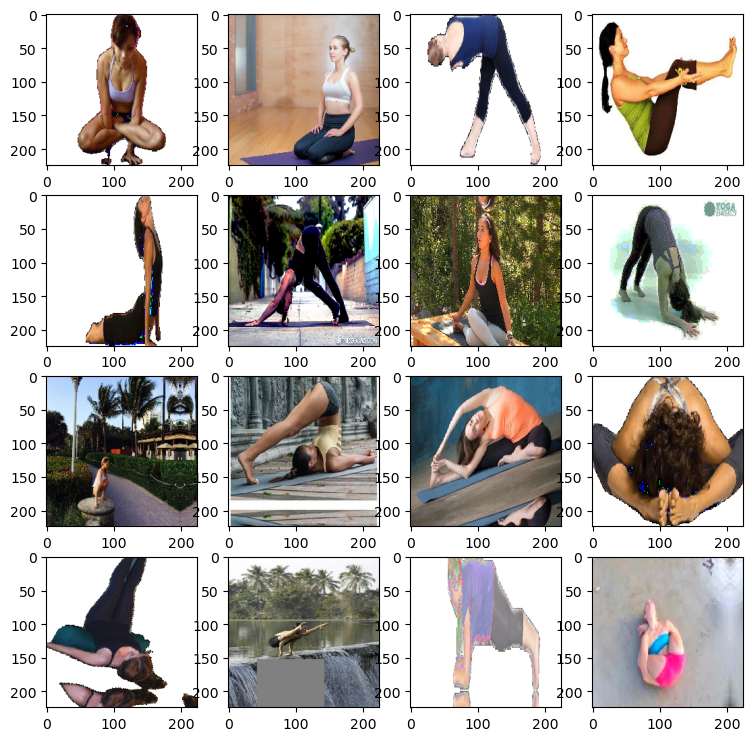

In [19]:
def plot_examples(dataset):
    
    _, axs = plt.subplots(4, 4, figsize=(9, 9))
    batch = next(dataset)[0]
    for row_idx, row in enumerate(axs):
        for clm_idx, ax in enumerate(row):
            ax.imshow(batch[4*row_idx+clm_idx].astype(int))

plot_examples(dataset_train)   

In [20]:
def create_encoder():
    eff_net = tf.keras.applications.MobileNetV3Large(
        include_top=False, weights="imagenet", input_shape=(width, height, 3), classes=6, dropout_rate=0.1
    )
    return eff_net

In [21]:
def get_pre_trained(body):
    inputs = Input(shape=(width, height, 3))

    head = tf.keras.Sequential()
    head_output = head(inputs) 

    body = body(head_output, training=True)

    tail = tf.keras.Sequential()
    tail.add(tf.keras.layers.GlobalMaxPooling2D())
    tail.add(Dense(6, activation='softmax', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.1, l2=0.1)))
    tail_output = tail(body)

    pre_trained = tf.keras.Model(inputs, tail_output)
    return pre_trained

In [22]:
eff_net = create_encoder()
eff_net.trainable = True

for layer in eff_net.layers[:int(len(eff_net.layers) * 0.5)]:
    layer.trainable = False

12683000/12683000 [==============================] - 0s 0us/step


In [23]:
pre_trained = get_pre_trained(eff_net)

In [24]:
pre_trained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     multiple                  0         
                                                                 
 MobilenetV3large (Function  (None, 7, 7, 960)         2996352   
 al)                                                             
                                                                 
 sequential_1 (Sequential)   (None, 6)                 5766      
                                                                 
Total params: 3002118 (11.45 MB)
Trainable params: 2802678 (10.69 MB)
Non-trainable params: 199440 (779.06 KB)
_________________________________________________________________


In [25]:
pre_trained.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=50,decay_rate=0.9,staircase=True)
), loss='categorical_crossentropy', metrics= [micro_f1_score, 'acc'])

In [26]:
history = pre_trained.fit(dataset_train, epochs=15, validation_data=dataset_val, max_queue_size=8)

Epoch 1/15
94/94 [==============================] - 761s 8s/step - loss: 22.0156 - micro_f1_score: 0.4176 - acc: 0.4170 - val_loss: 14.4645 - val_micro_f1_score: 0.5205 - val_acc: 0.5254
Epoch 2/15
94/94 [==============================] - 671s 7s/step - loss: 9.7028 - micro_f1_score: 0.6629 - acc: 0.6632 - val_loss: 6.0370 - val_micro_f1_score: 0.6201 - val_acc: 0.6271
Epoch 3/15
94/94 [==============================] - 669s 7s/step - loss: 3.8029 - micro_f1_score: 0.7433 - acc: 0.7435 - val_loss: 2.4541 - val_micro_f1_score: 0.6727 - val_acc: 0.6780
Epoch 4/15
94/94 [==============================] - 669s 7s/step - loss: 1.7587 - micro_f1_score: 0.7661 - acc: 0.7672 - val_loss: 1.5113 - val_micro_f1_score: 0.7240 - val_acc: 0.7288
Epoch 5/15
94/94 [==============================] - 670s 7s/step - loss: 1.1441 - micro_f1_score: 0.8023 - acc: 0.8042 - val_loss: 1.1672 - val_micro_f1_score: 0.7488 - val_acc: 0.7542
Epoch 6/15
94/94 [==============================] - 680s 7s/step - loss: 

In [27]:
pre_trained.evaluate(dataset_val_no_crop)

2/2 [==============================] - 1s 421ms/step - loss: 0.6807 - micro_f1_score: 0.8498 - acc: 0.8559


[0.6806901097297668, 0.8498263359069824, 0.8559321761131287]

In [28]:
plt.show()
%matplotlib inline
plt.show()
%matplotlib inline

[(0.0, 2.0)]

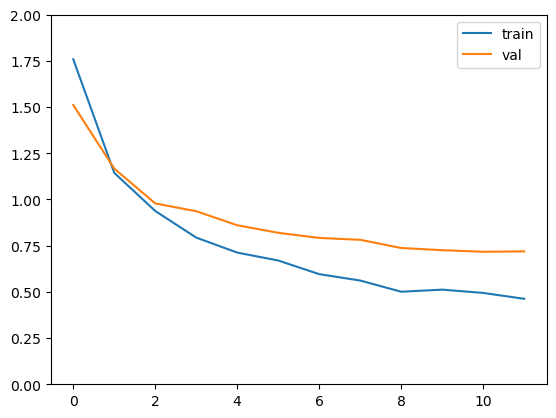

In [29]:
ax = sns.lineplot(history.history['loss'][3:], label='train')
sns.lineplot(history.history['val_loss'][3:], label='val')
ax.set(ylim=(0, 2))

In [30]:
model = pre_trained

In [31]:
def make_pred(model, X_train):
    y_pred = model.predict(np.array(X_train))
    y_pred_flipped =  model.predict(tf.image.flip_left_right(np.array(X_train))) 
    for idx, image in enumerate(X_train):
        X_train[idx] = get_cropped_image(X_train[idx])
    y_pred_crop = model.predict(np.array(X_train))
    y_pred_crop_flipped = model.predict(tf.image.flip_left_right(np.array(X_train))) 
    y_pred_weighted = (y_pred + y_pred_flipped + y_pred_crop + y_pred_crop_flipped) / 4
    return y_pred_weighted

In [32]:
from sklearn import metrics

def get_class_report(y_val_pred, y_val, target):
    print(metrics.classification_report(y_val.astype(str), y_val_pred.astype(str)))
    wrong_val = val.loc[y_val[y_val_pred != y_val].index]
    wrong_val['class_6'] = wrong_val['class_6'].astype(int)
    visualize_images(wrong_val, target)

In [33]:
def get_X(train):
    X_train = []
    for t in train['image_id']:
        X_train.append(plt.imread(path.join(test_src, t)))
    return X_train    
        
def get_shapes(X_train):
    sizes = []
    for x in X_train:
        sizes.append(x.shape)
    return sizes    

def get_greyscale(X_train):
    for idx in range(len(X_train)):
        if len(X_train[idx].shape) == 3:
            X_train[idx] = cv2.cvtColor(X_train[idx], cv2.COLOR_BGR2GRAY)
    for idx in range(len(X_train)):
        X_train[idx] = np.expand_dims(X_train[idx], -1)
    return X_train        
        
        
def get_resized(X_train, width, height):
    for idx in range(len(X_train)):
        X_train[idx] = cv2.resize(X_train[idx], (height, width)) 
    return X_train    

X_test = get_X(test)
X_test = get_resized(X_test, width, height)
X_test = get_greyscale(X_test)

In [34]:
X_test = tf.image.grayscale_to_rgb(tf.convert_to_tensor(np.array(X_test)))
X_test = X_test.numpy()

In [35]:
y_pred_pre_trained = make_pred(model, np.array(X_test))
test['class_6'] = np.argmax(y_pred_pre_trained, axis=1)

24/24 [==============================] - 1s 32ms/step


In [36]:
test

,image_id,class_6
0,18c514201d4d375596eaf057d43faa73.jpg,5
1,742cd45c52ee2d9a4745b27e1c5426a3.jpg,1
2,4ebf97acccead03c17d564c6701403ae.jpg,4
3,3a0fe12ec506d9fe99c0e370bce7eeef.jpg,3
4,d3442c050dd87db8b926b449408d793a.jpg,0
...,...,...
751,82689f579b379887337fbcc543d6e34e.jpg,2
752,3dd40670c0bb111d98f873679a31f0a3.jpg,4
753,3a57b3a17a5f0eed4f2a4b8a5fa8f81b.jpg,1
754,1ad75bfc569079f19e72fc44f47f76a6.jpg,4


In [37]:
test.to_csv('submission.csv', index=False)